# Pairs trading. Pairs selection. Distance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# read prices from csv file
prices = pd.read_csv('vbr16_19.csv', index_col='Date')

In [3]:
prices

,IEX,NUAN,MOH,NVAX,SBNY,PWR,WSM,FANG,BRO,STLD,...,RES,LE,APEI,FF,WK,PKI,ALGT,SAGE,OII,DRQ
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01,76.976616,13.567100,49.830002,149.800003,116.435783,22.887882,45.972996,85.069756,17.572161,21.910513,...,14.904593,16.760000,28.219999,5.362969,13.470000,51.718643,138.262650,31.100000,29.461021,59.099998
2016-07-05,75.590309,13.134199,48.240002,144.600006,113.829865,22.759472,44.250740,84.120781,17.387442,21.884090,...,14.506883,16.330000,26.690001,5.353037,13.450000,51.119549,134.303772,31.280001,28.251621,56.540001
2016-07-06,76.311562,13.151515,48.669998,149.199997,115.586044,23.174353,44.882534,85.032166,17.486902,22.482931,...,14.459538,16.100000,27.570000,5.372900,13.400000,51.512394,135.205246,32.320000,28.464476,56.830002
2016-07-07,76.798637,13.376623,48.959999,149.199997,117.115601,23.371920,44.666168,83.237549,17.425331,22.755930,...,14.345906,16.170000,27.799999,5.333174,13.560000,51.649891,135.381775,32.160000,28.396748,56.889999
2016-07-08,78.540871,13.722944,50.209999,152.399994,119.003944,24.063398,46.855759,83.773125,17.685837,23.460453,...,14.648921,16.700001,28.629999,5.556631,13.860000,52.985580,137.705048,33.970001,28.812782,57.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,170.038528,18.010000,136.649994,4.000000,131.962463,40.950520,70.886360,84.531479,38.795483,32.447666,...,5.050000,17.809999,27.330000,7.557316,41.470001,96.798271,179.097549,74.639999,15.090000,47.389999
2019-12-24,168.596710,18.000000,136.240005,4.000000,132.428436,40.712379,70.472260,85.623375,38.637653,32.664612,...,5.030000,17.580000,27.430000,7.600537,42.009998,97.037254,179.187057,76.800003,15.140000,47.410000
2019-12-26,169.420593,18.049999,136.380005,4.000000,133.185608,40.920746,71.271553,86.696274,38.834934,32.721199,...,5.110000,18.295000,27.910000,7.705499,41.740002,96.758453,177.973587,74.160004,15.090000,47.840000


In [5]:
cumret = np.log(prices).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True) 

# Functions to calculate different metrics

In [6]:
def calculate_distances(cumret):
    '''
    calculate Euclidean distance for each pair of stocks in the dataframe
    return sorted dictionary (in ascending order)
    '''
    distances = {} # dictionary with distance for each pair
    
    # calculate distances
    for s1 in cumret.columns:
        for s2 in cumret.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in distances.keys()) and (f'{s2}-{s1}' not in distances.keys()):
                dist = np.sqrt(np.sum((cumret[s1] - cumret[s2])**2)) # Euclidean distance
                distances[f'{s1}-{s2}'] = dist
    
    # sort dictionary
    sorted_distances = {k:v for k,v in sorted(distances.items(), key = lambda item: item[1])}
    
    return sorted_distances

def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]
    
    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint
    
    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]
    
    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]
    
    return halflife

def calculate_metrics(sorted_distances, cumret, N=5):
    '''
    calculate metrics for N pairs with the smallest Euclidean distance
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    
    pairs = [k for k,v in sorted_distances.items()][:N]
    
    cols = ['Euclidean distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread = cumret[s1] - cumret[s2]
        results.loc[pair]['Euclidean distance'] = np.sqrt(np.sum((spread)**2))
        results.loc[pair]['CADF p-value'] = cadf_pvalue(s1, s2, cumret)
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        results.loc[pair]['Spread SD'] = spread.std()
        results.loc[pair]['Num zero-crossings'] = ((spread[1:].values * spread[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within 2-SD band'] = (abs(spread) < 2*spread.std()).sum() / len(spread) * 100
        
    return results

def plot_pairs(sorted_distances, cumret_train, cumret_test, N=5):
    '''
    plot cumulative returns of the spread for each of N pairs with smallest Euclidean distance
    '''
    pairs = [k for k,v in sorted_distances.items()][:N]
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread_train = cumret_train[s1] - cumret_train[s2]
        spread_test = cumret_test[s1] - cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

## 12 months formation period \ 6 months trading period

In [7]:
# prepare data
cumret12_6 = cumret.loc['2018-07-01':]
cumret12_6 = cumret12_6 / cumret12_6.iloc[0] # divide by first row so that all prices start at 1
train12_6 = cumret12_6.loc['2018-07-01':'2019-06-31'] # formation period
test12_6 = cumret12_6.loc['2019-07-01':'2019-12-31'] # trading period

In [23]:
# calculate Euclidean distances for each pair
sorted_distances12_6 = calculate_distances(train12_6)

In [25]:
# print top 10 pairs with smallest distance
[[k,v] for k,v in sorted_distances12_6.items()][:10]

[['BXMT-PMT', 0.18534667592937973],
 ['ZION-CFR', 0.19955368463211864],
 ['CBSH-CVBF', 0.23162338738613775],
 ['CVBF-NBTB', 0.25639422937549716],
 ['CBSH-NBTB', 0.2740192531721768],
 ['CFR-SHO', 0.279677759296359],
 ['CENTA-CENT', 0.28650499260947404],
 ['UCBI-PRK', 0.290254830655206],
 ['CUZ-HPP', 0.2933625746003759],
 ['PACW-HOMB', 0.2972769080754797]]

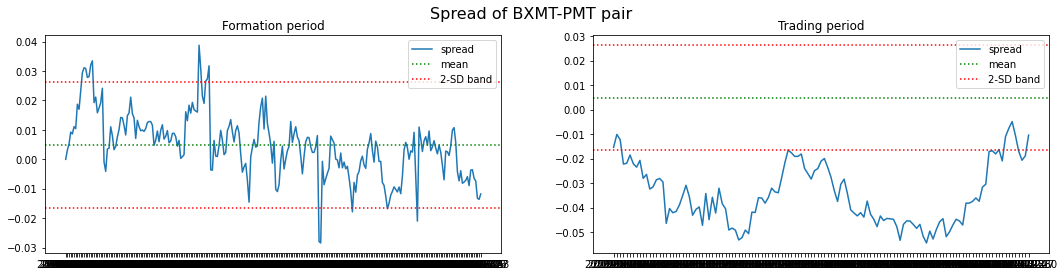

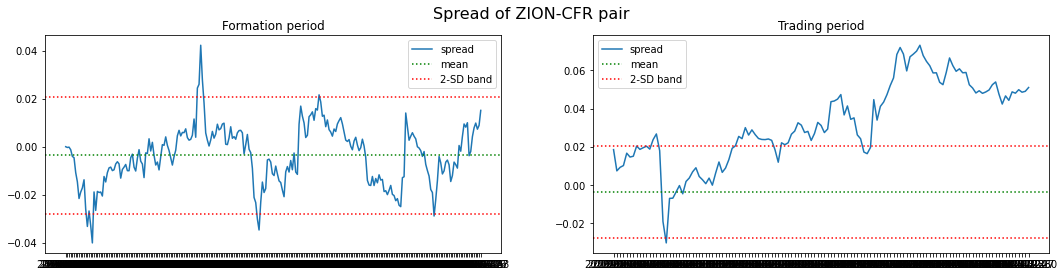

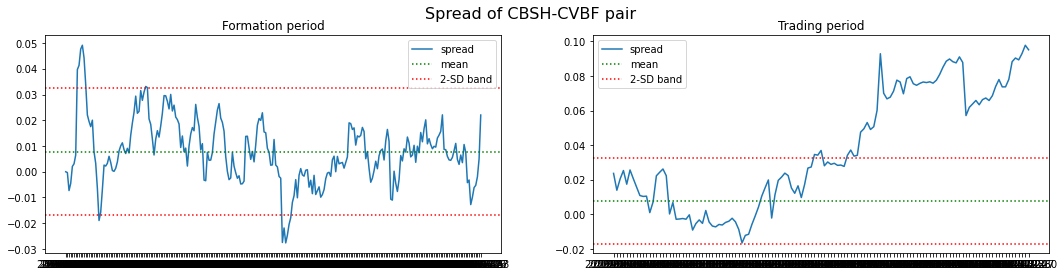

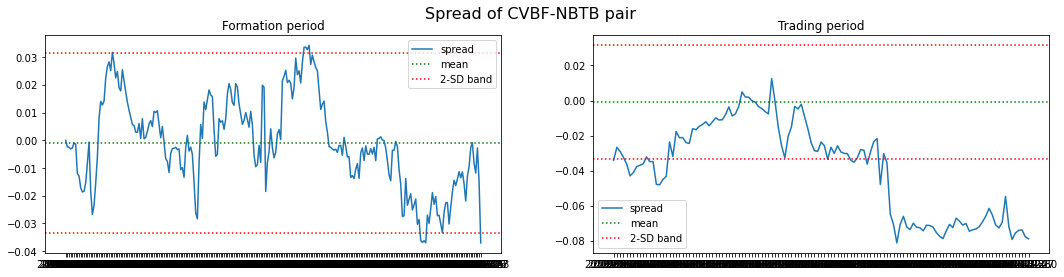

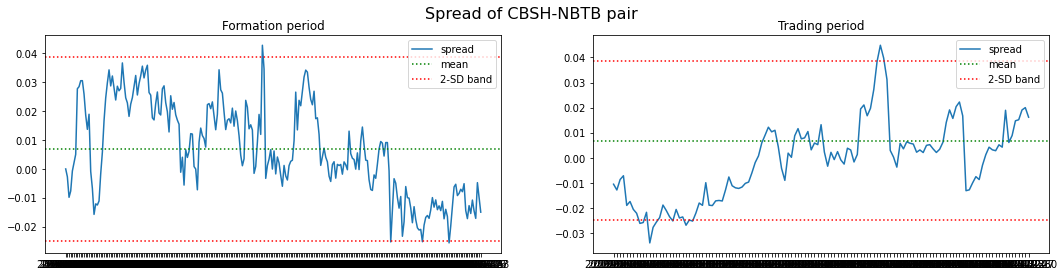

In [9]:
plot_pairs(sorted_distances12_6, train12_6, test12_6)

#### Metrics for top5 pairs during 12m formation period

In [10]:
calculate_metrics(sorted_distances12_6, train12_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
BXMT-PMT,0.185347,0.000049,0.014721,0.010702,31,0.317424,3.57473,92.8
ZION-CFR,0.199554,0.033698,0.008456,0.012107,23,0.4535,7.067607,94.0
CBSH-CVBF,0.231623,0.004689,0.001875,0.012397,23,0.385377,5.819853,91.6
CVBF-NBTB,0.256394,0.177118,0.143461,0.016222,18,0.322994,9.735489,96.0
CBSH-NBTB,0.274019,0.046744,0.042703,0.015919,36,0.306952,7.180554,94.8


#### Metrics for top5 pairs during 6m trading period

In [11]:
calculate_metrics(sorted_distances12_6, test12_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
BXMT-PMT,0.412001,0.342681,0.147309,0.012238,0,0.39562,9.363208,25.984252
ZION-CFR,0.437946,0.227423,0.475875,0.021742,4,0.520924,16.311516,62.204724
CBSH-CVBF,0.569369,0.005272,0.868795,0.033958,6,0.643906,59.468393,71.653543
CVBF-NBTB,0.527637,0.004559,0.713055,0.026426,4,0.600112,26.28249,66.141732
CBSH-NBTB,0.175541,0.201849,0.221612,0.015593,15,0.490445,9.136463,96.062992


## 24 months formation period \ 6 months trading period

In [12]:
# prepare data
cumret24_6 = cumret.loc['2017-07-01':]
cumret24_6 = cumret24_6 / cumret24_6.iloc[0] # divide by first row so that all prices start at 1
train24_6 = cumret24_6.loc['2017-07-01':'2019-06-31'] # formation period
test24_6 = cumret24_6.loc['2019-07-01':'2019-12-31'] # trading period

In [28]:
# calculate Euclidean distances for each pair
sorted_distances24_6 = calculate_distances(train24_6)

In [29]:
# print top 10 pairs with smallest distance
[[k,v] for k,v in sorted_distances24_6.items()][:10]

[['AGNC-MFA', 0.48389477832676514],
 ['CENTA-CENT', 0.49176405060607475],
 ['MTG-ESNT', 0.5020148240022925],
 ['BANF-STBA', 0.534333722623322],
 ['STWD-CIM', 0.5495869561327438],
 ['WBS-WSBC', 0.5589548024641623],
 ['ATO-OGS', 0.5657027989342371],
 ['CUZ-DEI', 0.5727710511922683],
 ['PBCT-BXS', 0.5760029939629536],
 ['APLE-SHO', 0.5856976838193417]]

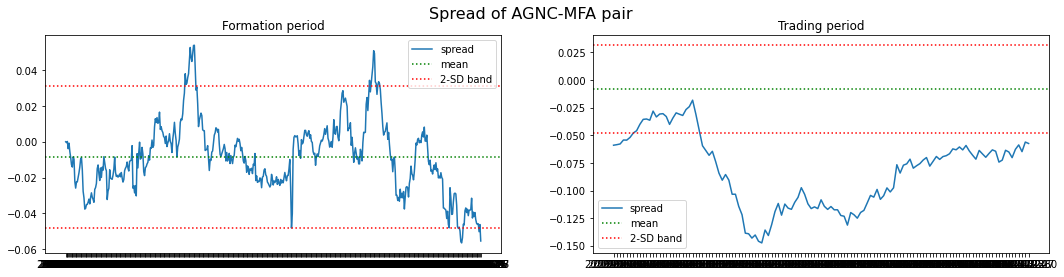

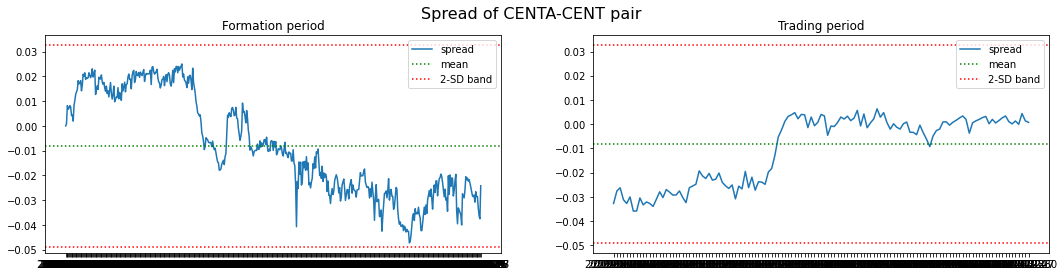

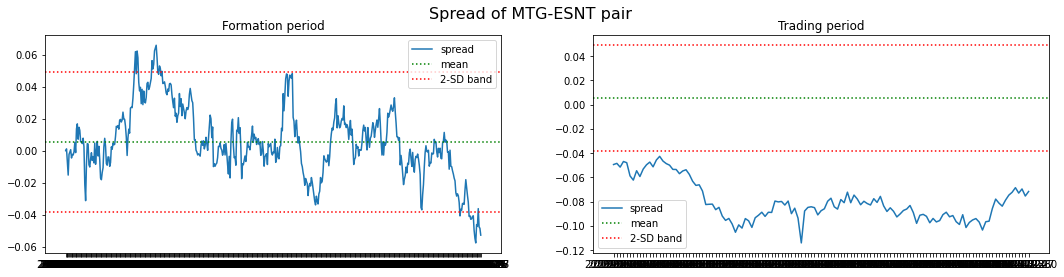

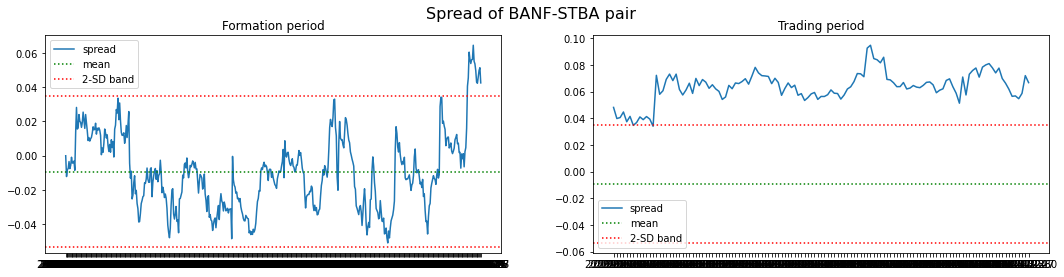

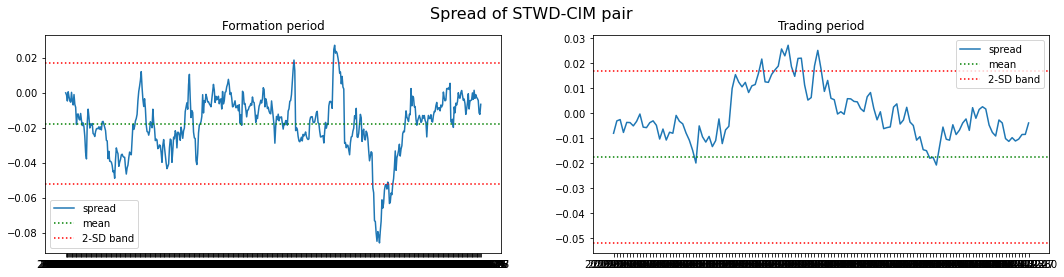

In [30]:
plot_pairs(sorted_distances24_6, train24_6, test24_6)

#### Metrics for top5 pairs during 24m formation period

In [31]:
calculate_metrics(sorted_distances24_6, train24_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
AGNC-MFA,0.483895,0.028539,0.075943,0.019913,40,0.423158,20.804235,92.61477
CENTA-CENT,0.491764,0.563301,0.655236,0.020406,5,0.46989,45.157262,97.60479
MTG-ESNT,0.502015,0.112887,0.081364,0.021781,71,0.403968,16.402089,93.213573
BANF-STBA,0.534334,0.052796,0.017621,0.021983,27,0.32923,14.985708,94.211577
STWD-CIM,0.549587,0.016817,0.00428,0.01719,36,0.371338,13.193009,86.027944


#### Metrics for top5 pairs during 6m trading period

In [32]:
calculate_metrics(sorted_distances24_6, test24_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
AGNC-MFA,0.995805,0.776867,0.73309,0.032912,0,0.623126,38.443445,36.220472
CENTA-CENT,0.193742,0.195765,0.653734,0.013961,23,0.635465,20.870645,85.03937
MTG-ESNT,0.920918,0.583281,0.211029,0.016205,0,0.514126,9.367991,0.0
BANF-STBA,0.726726,0.119351,0.038373,0.011242,0,0.462654,3.733469,0.0
STWD-CIM,0.119945,0.16874,0.078432,0.010683,16,0.498757,6.450339,94.488189


## 36 months formation period \ 6 months trading period

In [17]:
# prepare data
cumret36_6 = cumret.loc['2016-07-01':]
cumret36_6 = cumret36_6 / cumret36_6.iloc[0] # divide by first row so that all prices start at 1
train36_6 = cumret36_6.loc['2016-07-01':'2019-06-31'] # formation period
test36_6 = cumret36_6.loc['2019-07-01':'2019-12-31'] # trading period

In [33]:
# calculate Euclidean distances for each pair
sorted_distances36_6 = calculate_distances(train36_6)

In [34]:
# print top 10 pairs with smallest distance
[[k,v] for k,v in sorted_distances36_6.items()][:10]

[['CENTA-CENT', 0.6676391478191526],
 ['CATY-BXS', 0.8623591382530676],
 ['OGS-NJR', 0.9100233351171999],
 ['POR-PNW', 0.933409249942717],
 ['AUB-BRKL', 0.9454275230286255],
 ['BXMT-ARI', 0.9801674175907916],
 ['IDA-OGS', 0.9955929228112151],
 ['BXS-CVBF', 1.0439644618397024],
 ['TRMK-NBTB', 1.045741548135903],
 ['WTM-EQC', 1.0495189596604633]]

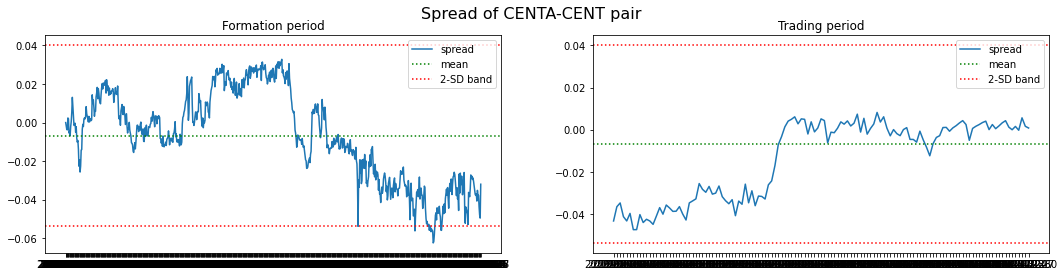

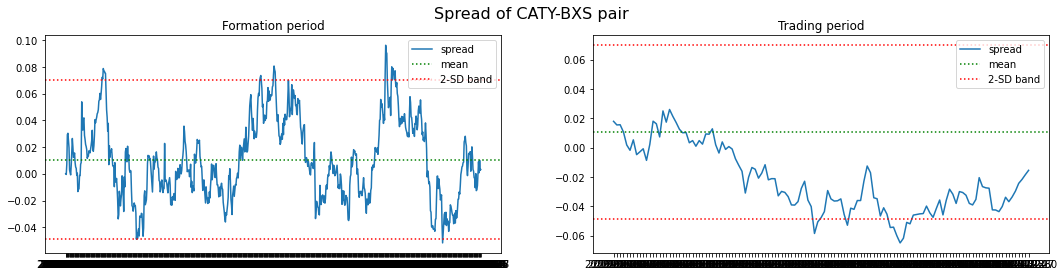

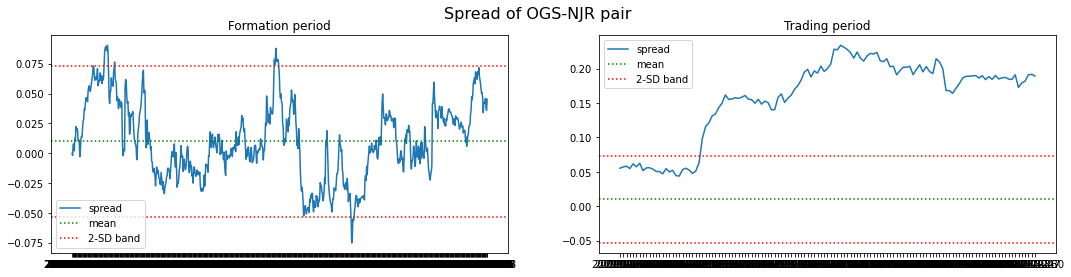

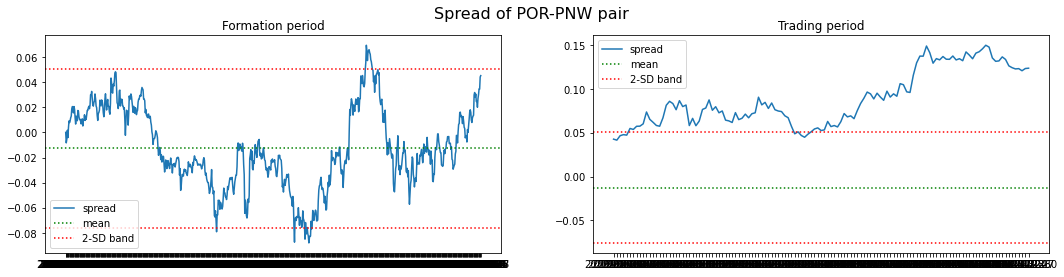

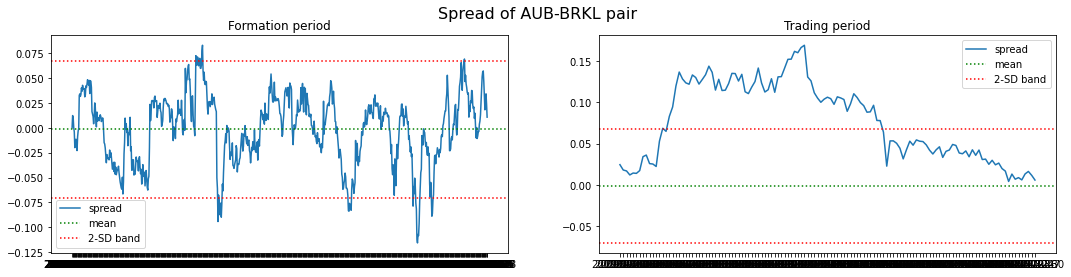

In [35]:
plot_pairs(sorted_distances36_6, train36_6, test36_6)

#### Metrics for top5 pairs during 36m formation period

In [36]:
calculate_metrics(sorted_distances36_6, train36_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
CENTA-CENT,0.667639,0.563643,0.424566,0.023407,36,0.438827,38.422699,94.81383
CATY-BXS,0.862359,0.014778,0.003222,0.02962,63,0.349063,18.626838,93.617021
OGS-NJR,0.910023,0.026148,0.006273,0.031617,71,0.383592,23.498973,94.148936
POR-PNW,0.933409,0.328713,0.163687,0.031596,13,0.467051,42.696987,92.553191
AUB-BRKL,0.945428,0.00038,0.000061,0.034478,58,0.34541,13.124251,95.611702


#### Metrics for top5 pairs during 6m trading period

In [37]:
calculate_metrics(sorted_distances36_6, test36_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
CENTA-CENT,0.255688,0.195765,0.65341,0.018356,23,0.635317,20.851747,84.251969
CATY-BXS,0.358071,0.280637,0.199723,0.022483,9,0.533955,11.466655,84.251969
OGS-NJR,1.896729,0.399767,0.419226,0.057537,0,0.726039,31.775226,20.472441
POR-PNW,1.062727,0.028765,0.586697,0.03192,0,0.58281,25.996593,26.771654
AUB-BRKL,1.019298,0.115545,0.716331,0.047032,0,0.599827,30.390113,53.543307
